In [1]:
import os
os.environ["OMP_NUM_THREADS"] = "12"
os.environ["OPENBLAS_NUM_THREADS"] = "12"
os.environ["MKL_NUM_THREADS"] = "12"

import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path
import joblib
from joblib import parallel_backend, Memory

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score, f1_score, confusion_matrix

RANDOM_STATE = 42

CACHE_DIR = Path("../cache/tfidf")
CACHE_DIR.mkdir(parents=True, exist_ok=True)
memory = Memory(location=str(CACHE_DIR), verbose=0)

MODELS_DIR = Path("../models")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

In [2]:
from threadpoolctl import threadpool_info
threadpool_info()

[{'user_api': 'openmp',
  'internal_api': 'openmp',
  'num_threads': 12,
  'prefix': 'libgomp',
  'filepath': '/usr/lib/libgomp.so.1.0.0',
  'version': None}]

In [3]:
df = pd.read_csv("../data/processed/processed-data.csv")

print(df.shape)
df.head(2)

(334305, 2)


,reviewText_clean,ratingRounded
0,heerlijk eten en leuke sfeer. veel keuze bij h...,4.5
1,met z n vieren dit restaurant bezocht. we hadd...,5.0


In [4]:
X = df["reviewText_clean"].astype(str)
y_reg = df["ratingRounded"].astype(float)
y_cls = (y_reg * 2).astype(int)  # 0.5 ster = 1 stap

X_train, X_test, y_reg_train, y_reg_test, y_cls_train, y_cls_test = train_test_split(
    X, y_reg, y_cls,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y_cls
)

print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")


Train size: 267444, Test size: 66861


In [5]:
# TF-IDF configuration
tfidf_word = TfidfVectorizer(
    ngram_range=(1, 2),
    min_df=5,
    max_df=0.9,
    sublinear_tf=True,
    strip_accents="unicode",
    dtype=np.float32
)

tfidf_char = TfidfVectorizer(
    analyzer="char",
    ngram_range=(3, 5),
    min_df=5,
    sublinear_tf=True,
    dtype=np.float32
)

features = FeatureUnion([
    ("tfidf_word", tfidf_word),
    ("tfidf_char", tfidf_char),
]) 


In [6]:
# Ridge Regression baseline
reg_pipeline = Pipeline([
    ("feat", features),
    ("model", Ridge(alpha=2.0, random_state=RANDOM_STATE))
], memory=memory)

t0 = time.time()
with parallel_backend("threading", n_jobs=-1):
    reg_pipeline.fit(X_train, y_reg_train)
print(f"[REG] fit time: {time.time() - t0:.1f}s")

# ⬇️ Automatisch checkpointen
joblib.dump(reg_pipeline, MODELS_DIR / "baseline_tfidf_ridge.joblib")

y_pred_reg = reg_pipeline.predict(X_test)
y_pred_reg_rounded = np.round(np.clip(y_pred_reg, 0, 5) * 2) / 2

mae = mean_absolute_error(y_reg_test, y_pred_reg)
try:
    rmse = mean_squared_error(y_reg_test, y_pred_reg, squared=False)
else:
    rmse = mean_squared_error(y_reg_test, y_pred_reg) ** 0.5
within_half = np.mean(np.abs(y_pred_reg_rounded - y_reg_test) <= 0.5)

print(f"[REG] MAE={mae:.3f} | RMSE={rmse:.3f} | within-0.5={within_half:.3f}")

[REG] fit time: 161.9s
[REG] MAE=0.384 | RMSE=0.489 | within-0.5=0.894


In [7]:
# Logistic Regression baseline
cls_pipeline = Pipeline([
    ("feat", features),
    ("model", LogisticRegression(
        solver="saga",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        verbose=1
    ))
], memory=memory)

t0 = time.time()
with parallel_backend("threading", n_jobs=-1):
    cls_pipeline.fit(X_train, y_cls_train)
print(f"[CLS] fit time: {time.time() - t0:.1f}s")

# ⬇️ Automatisch checkpointen
joblib.dump(cls_pipeline, MODELS_DIR / "baseline_tfidf_logreg_saga.joblib")

y_pred_cls = cls_pipeline.predict(X_test)

acc = accuracy_score(y_cls_test, y_pred_cls)
f1m = f1_score(y_cls_test, y_pred_cls, average="macro")
within_half_cls = np.mean(np.abs(y_pred_cls - y_cls_test) <= 1)

print(f"[CLS] ACC={acc:.3f} | F1_macro={f1m:.3f} | within-0.5={within_half_cls:.3f}")

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


Epoch 1, change: 1
Epoch 2, change: 0.62452006
Epoch 3, change: 0.51583481
Epoch 4, change: 0.64160895
Epoch 5, change: 0.68092108
Epoch 6, change: 0.84094673
Epoch 7, change: 0.56563401
Epoch 8, change: 0.8348819
Epoch 9, change: 0.56116331
Epoch 10, change: 0.67681628
Epoch 11, change: 0.67612255
Epoch 12, change: 1.2819427
Epoch 13, change: 0.78359252
Epoch 14, change: 0.6731928
Epoch 15, change: 0.60864478
Epoch 16, change: 0.53668511
Epoch 17, change: 0.48855054
Epoch 18, change: 0.50774616
Epoch 19, change: 0.99098152
Epoch 20, change: 0.62870085
Epoch 21, change: 0.61226159
Epoch 22, change: 0.74862522
Epoch 23, change: 0.5476805
Epoch 24, change: 0.50529557
Epoch 25, change: 0.73117286
Epoch 26, change: 0.74173629
Epoch 27, change: 0.61876994
Epoch 28, change: 0.55556369
Epoch 29, change: 0.54485321
Epoch 30, change: 0.54681504
Epoch 31, change: 0.9283461
Epoch 32, change: 0.86176503
Epoch 33, change: 0.75955743
Epoch 34, change: 0.78788137
Epoch 35, change: 0.78258681
Epoch 36

/usr/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CLS] ACC=0.425 | F1_macro=0.250 | within-0.5=0.792


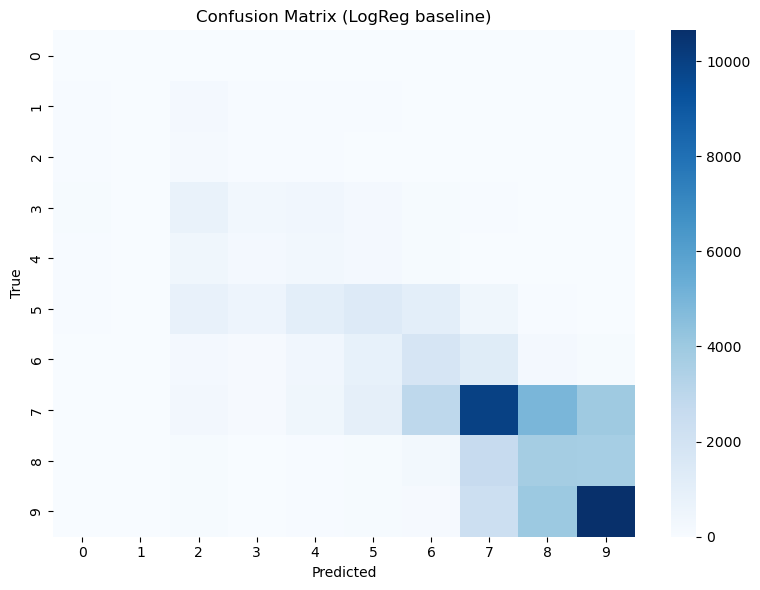

In [8]:
cm = confusion_matrix(y_cls_test, y_pred_cls, labels=range(1, 11))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=False, cmap="Blues")
plt.title("Confusion Matrix (LogReg baseline)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


In [1]:
# Cross-validation
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score

reg_pipeline_cv = Pipeline([
    ("feat", features),
    ("model", Ridge(alpha=2.0, random_state=RANDOM_STATE))
], memory=memory)

cls_pipeline_cv = Pipeline([
    ("feat", features),
    ("model", LogisticRegression(
        solver="saga",
        max_iter=1000,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        verbose=0
    ))
], memory=memory)

kf = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

reg_cv = cross_val_score(
    reg_pipeline_cv, X, y_reg,
    cv=kf, scoring="neg_mean_absolute_error", n_jobs=1
)
cls_cv = cross_val_score(
    cls_pipeline_cv, X, y_cls,
    cv=skf, scoring="accuracy", n_jobs=1
)

print(f"[REG CV] MAE={(-reg_cv).mean():.3f} ± {(-reg_cv).std():.3f}")
print(f"[CLS CV] ACC={cls_cv.mean():.3f} ± {cls_cv.std():.3f}")


NameError: name 'RANDOM_STATE' is not defined

In [ ]:
import joblib
from pathlib import Path

out_dir = Path("../models")
out_dir.mkdir(parents=True, exist_ok=True)

joblib.dump(reg_pipeline, out_dir / "baseline_tfidf_ridge.joblib")
joblib.dump(cls_pipeline, out_dir / "baseline_tfidf_logreg.joblib")

print("Models saved in:", out_dir)